## This notebook is a demonstration of the usage of Intel's OpenVino [horizontal text detections model](https://docs.openvino.ai/latest/omz_models_model_horizontal_text_detection_0001.html) for detection on [Total Text Dataset](https://www.kaggle.com/datasets/ipythonx/totaltextstr) with the help of the open source tool [FiftyOne](https://docs.voxel51.com/index.html) for horizontal text detection

### Prequisites
   - Get the [Total Text Dataset](https://www.kaggle.com/datasets/ipythonx/totaltextstr) downloaded in the same path where you have 
   where you have the notebook
   - Clone the openvino notebooks [repo](https://github.com/openvinotoolkit/openvino_notebooks) in the same path where you have 
   where you have the notebook
   - Run the below code cell to get the required python libraries

In [ ]:
# !pip install fiftyone
# !pip install cv2
# !pip install openvino
# !pip install numpy

## Imports 

In [8]:
import fiftyone as fo
import os
import glob
import cv2
import re
import numpy as np
from openvino.runtime import Core

## Load dataset into FiftyOne

In [10]:
# Create samples for your data
samples = []
for dataname in ['Train', 'Test']:
    images_patt = "./Total-Text/"+dataname+"/*"
    # Looping through the images path to add samples to the dataset
    for filepath in glob.glob(images_patt):
        sample = fo.Sample(filepath=filepath,tags=[dataname])
        # Get height, width of image
        img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        height = img.shape[0]
        width = img.shape[1]
        
        # Getting the filename from the filepath         
        filename=filepath.split("\\")[-1].split(".")[0]
        
        # Following test images are avoided due to incorrect formatting of their polygonal annnotations .txt file        
        test_images_to_avoid=['img551','img621','img623']
        
        if filename not in test_images_to_avoid:
            # Path to polygonal annotation
            annotation_path="./Total-Text/Annotation/groundtruth_polygonal_annotation/"+dataname+"/poly_gt_"+filename+".txt"
            with open(annotation_path, "r") as f:
                polylines = []               
                lines = f.readlines()
                for line in lines:
                    # extract key-value pairs using regular expressions
                    x = re.findall(r'\d+\.\d+|\d+', line.split(',')[0])
                    y = re.findall(r'\d+\.\d+|\d+', line.split(',')[1])
                    if(len(re.findall(r'[a-z]+|\#', line.split(',')[2])))==3:
                        ornt = re.findall(r'[a-z]+|\#', line.split(',')[2])[2]
                    else:
                        ornt = "no_value" 
                    if(len(re.findall(r'[A-Za-z]+|\#|\d+', line.split(',')[3])))==3:
                        transcriptions = re.findall(r'[A-Za-z]+|\#|\d+', line.split(',')[3])[2]
                    else:
                        transcriptions = "no_label"
                        
                    # normalize x and y values between 0 and 1 using the image height and width
                    x = [round(float(i)/width, 2) for i in x]
                    y = [round(float(i)/height, 2) for i in y]
                    points = [list(zip(x, y))]
                    
                    # polyline=fo.Polyline(label=transcriptions,points=points,closed=True)
                    # In case of horizontal text detection, the OpenVino model just gives us the bounding box.
                    # so for the purpose of the model we won't provide ground_truth labels. In case you are testing with 
                    # the model that does have labels for text detected you can uncomment the above code line and comment out
                    # the below line                    
                    polyline=fo.Polyline(points=points,closed=True)
                    
                    polylines.append(polyline)
            sample["ground_truth_polylines"] = fo.Polylines(polylines=polylines)
            sample["ground_truth"] = sample["ground_truth_polylines"].to_detections()
            samples.append(sample)
            
# Create dataset
dataset = fo.Dataset("fo-Total-Text-dataset")
dataset.add_samples(samples)    

 100% |███████████████| 1552/1552 [9.0s elapsed, 0s remaining, 162.1 samples/s]       


['6467c989d4c1e0c79de4988c',
 '6467c989d4c1e0c79de4988d',
 '6467c989d4c1e0c79de4988e',
 '6467c989d4c1e0c79de4988f',
 '6467c989d4c1e0c79de49890',
 '6467c989d4c1e0c79de49891',
 '6467c989d4c1e0c79de49892',
 '6467c989d4c1e0c79de49893',
 '6467c989d4c1e0c79de49894',
 '6467c989d4c1e0c79de49895',
 '6467c989d4c1e0c79de49896',
 '6467c989d4c1e0c79de49897',
 '6467c989d4c1e0c79de49898',
 '6467c989d4c1e0c79de49899',
 '6467c989d4c1e0c79de4989a',
 '6467c989d4c1e0c79de4989b',
 '6467c989d4c1e0c79de4989c',
 '6467c989d4c1e0c79de4989d',
 '6467c989d4c1e0c79de4989e',
 '6467c989d4c1e0c79de4989f',
 '6467c989d4c1e0c79de498a0',
 '6467c989d4c1e0c79de498a1',
 '6467c989d4c1e0c79de498a2',
 '6467c989d4c1e0c79de498a3',
 '6467c989d4c1e0c79de498a4',
 '6467c989d4c1e0c79de498a5',
 '6467c989d4c1e0c79de498a6',
 '6467c989d4c1e0c79de498a7',
 '6467c989d4c1e0c79de498a8',
 '6467c989d4c1e0c79de498a9',
 '6467c989d4c1e0c79de498aa',
 '6467c989d4c1e0c79de498ab',
 '6467c989d4c1e0c79de498ac',
 '6467c989d4c1e0c79de498ad',
 '6467c989d4c1

## Launch the fiftyone app to view the dataset


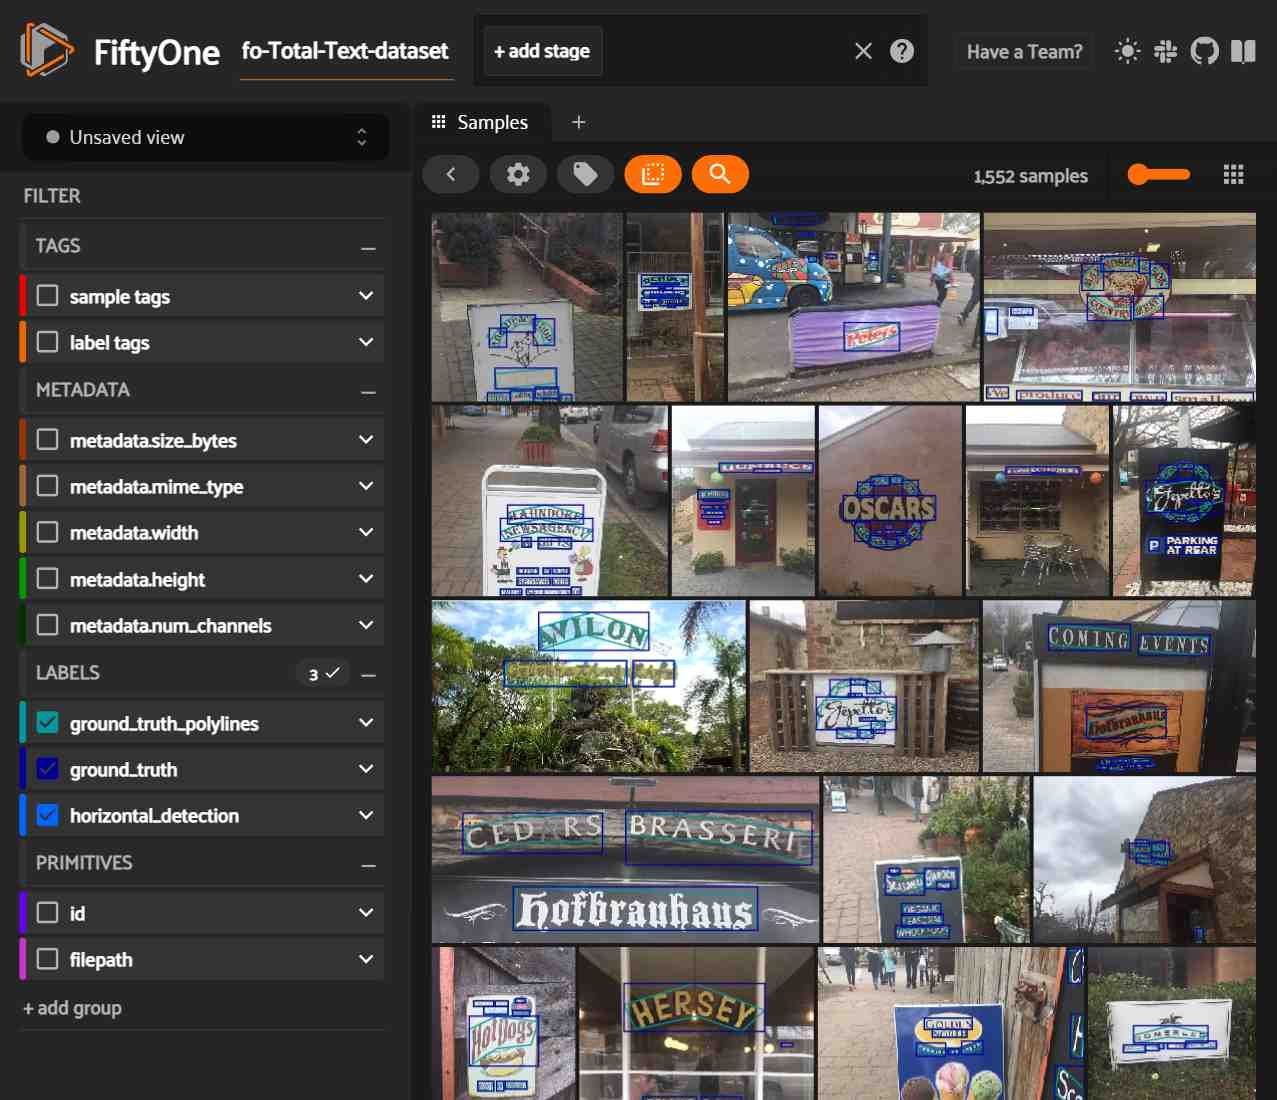

In [11]:
session = fo.launch_app(dataset=dataset)

### Check the sample tags 


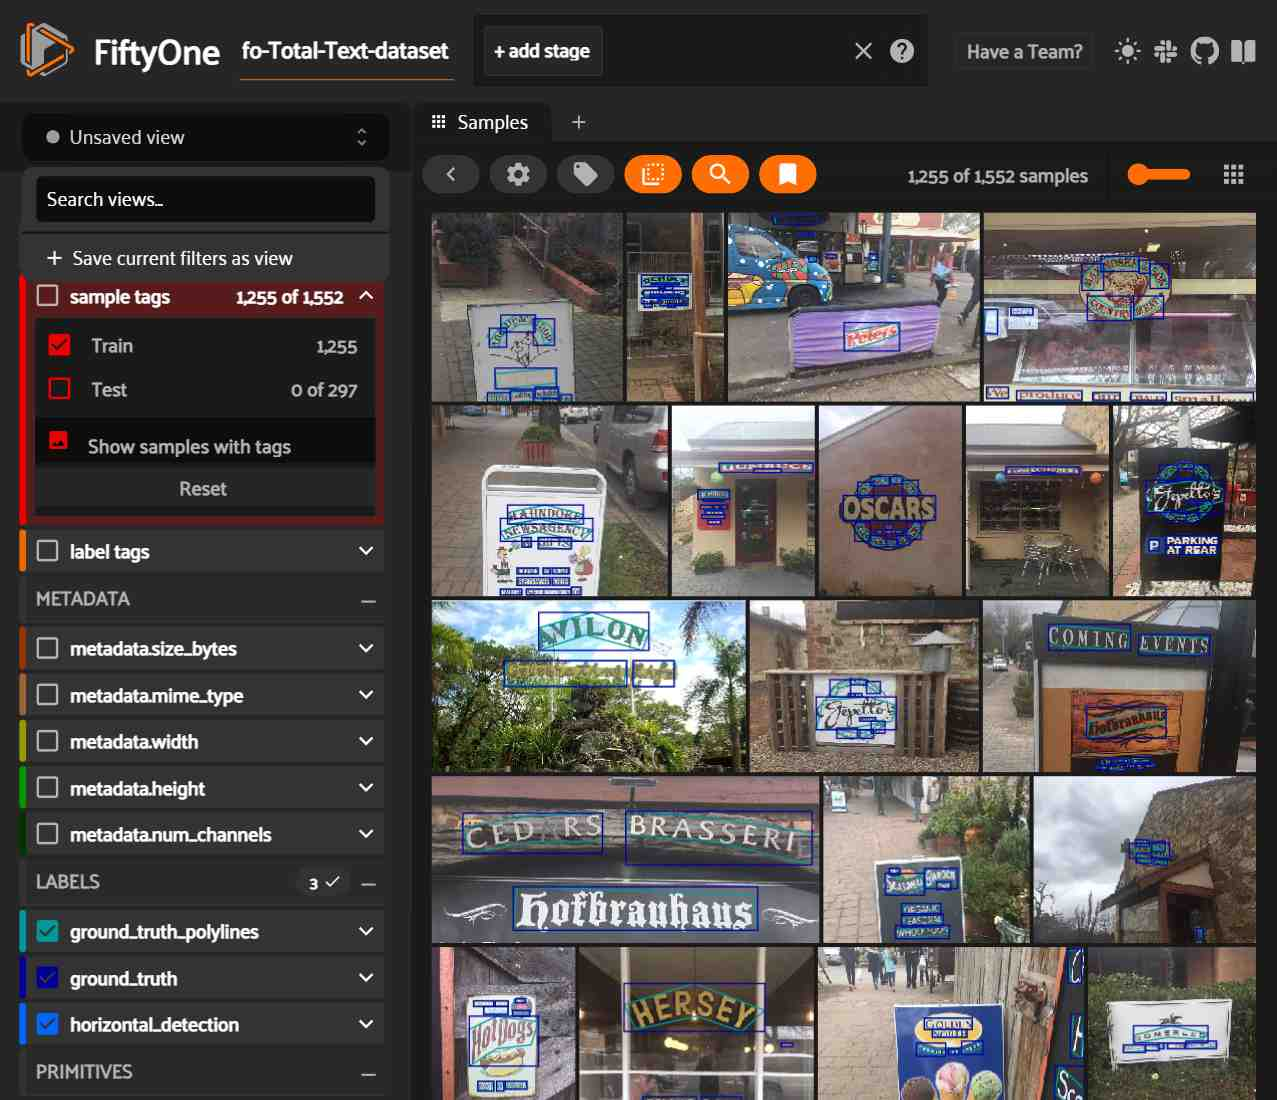

In [21]:
session.view = None

In [13]:
# Print some information about the dataset
print(dataset)

Name:        fo-Total-Text-dataset
Media type:  image
Num samples: 1552
Persistent:  False
Tags:        []
Sample fields:
    id:                     fiftyone.core.fields.ObjectIdField
    filepath:               fiftyone.core.fields.StringField
    tags:                   fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:               fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth_polylines: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Polylines)
    ground_truth:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [14]:
# Print a ground truth detection
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '6467c96ed4c1e0c79de43216',
    'attributes': {},
    'tags': [],
    'label': None,
    'bounding_box': [0.3, 0.61, 0.09000000000000002, 0.09999999999999998],
    'mask': None,
    'confidence': None,
    'index': None,
}>


## Add predictions to dataset

In [15]:
# predictions_view = dataset.match_tags(["Train", "Test"]) # for whole dataset
predictions_view = dataset.match_tags(["Test"]) # for test dataset

### Let's load the OpenVino model

In [16]:
ie = Core()

model = ie.read_model(model="./openvino_notebooks/notebooks/004-hello-detection/model/horizontal-text-detection-0001.xml")
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output("boxes")

### Add predictions to samples

In [17]:
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Text detection models expect an image in BGR format.
        img = cv2.imread(sample.filepath)

        # height, width of image
        height = img.shape[0]
        width = img.shape[1]
        # N,C,H,W = batch size, number of channels, height, width.
        N, C, H, W = input_layer_ir.shape

        # Resize the image to meet network expected input sizes.
        resized_image = cv2.resize(img, (W, H))

        # Reshape to the network input shape.
        input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)
        
        # Create an inference request.
        boxes = compiled_model([input_image])[output_layer_ir]

        # Remove zero only boxes.
        boxes = boxes[~np.all(boxes == 0, axis=1)]
        
        # Getting the ratio of resized images and original image to avoid getting bounding boxes at wrong location
        (real_y, real_x), (resized_y, resized_x) = img.shape[:2], resized_image.shape[:2]
        ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

        # Convert detections to FiftyOne format
        detections = []
        for i in range(len(boxes)):
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image, 
            # position the upper box bar little lower to make it visible on the image. 
            (x1, y1, x2, y2) = [
                int(max(corner_position * ratio_y, 10)) if idx % 2 
                else int(corner_position * ratio_x)
                for idx, corner_position in enumerate(boxes[i][:-1])
            ]
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            rel_box = [x1 / width, y1 / height, (x2 - x1) / width, (y2 - y1) / height]
            detections.append(
                fo.Detection(    
                bounding_box=rel_box,  
                confidence=boxes[i][4]
                )
            )
        sample["horizontal_detection"] = fo.Detections(detections=detections)
        sample.save()  

 100% |█████████████████| 297/297 [20.6s elapsed, 0s remaining, 14.8 samples/s]      



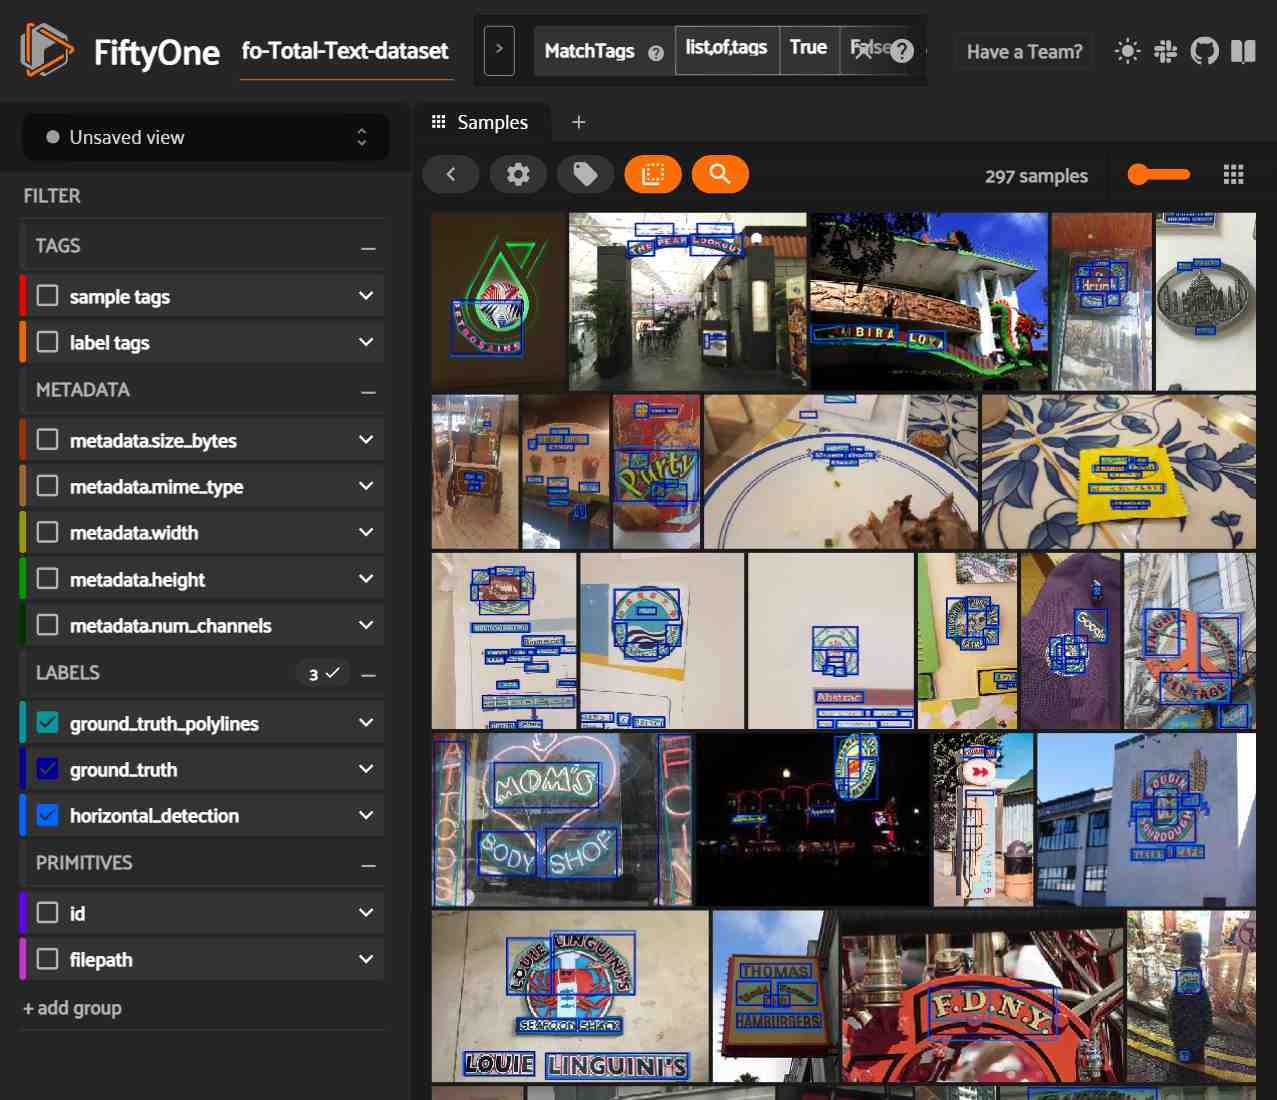

In [22]:
session.view = predictions_view

### Check the detections

In [23]:
session.show()

## Evaluate detections

In [19]:
results = predictions_view.evaluate_detections(
    "horizontal_detection", gt_field="ground_truth",use_boxes=True, classwise=False, compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 297/297 [2.5s elapsed, 0s remaining, 107.7 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 297/297 [4.4s elapsed, 0s remaining, 57.4 samples/s]      


Since with the OpenVino's horizontal detection model, it only gives out bounding box detection but no labels for the text detected, therefore, while evaluating detection using `evaluate_detection` function, the `classwise` parameter is set to `False` and also ground_truth labels for text detected are not added to dataset. For a model that returns label for text detected, you can set `classwise` to `True` and add the ground truth labels to dataset.

In [ ]:
# results.metrics()